In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
from collections import namedtuple
Intrinsics = namedtuple('Intrinsics', ['height', 'width', 'fx', 'fy', 'cx', 'cy', 'near', 'far'])

In [3]:
def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P


intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)

def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]


def intrinsics_to_rasterizer(intrinsics, camera_pose_jax):

    fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2.0
    fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2.0
    tan_fovx = math.tan(fovX)
    tan_fovy = math.tan(fovY)

    proj_matrix = getProjectionMatrix(0.01, 100.0, fovX, fovY).transpose(0,1).cuda()
    view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose_jax))),0,1).cuda()

    raster_settings = GaussianRasterizationSettings(
        image_height=int(intrinsics.height),
        image_width=int(intrinsics.width),
        tanfovx=tan_fovx,
        tanfovy=tan_fovy,
        bg=torch.tensor([0.0, 0.0, 0.0]).cuda(),
        scale_modifier=1.0,
        viewmatrix=view_matrix,
        projmatrix=view_matrix @ proj_matrix,
        sh_degree=0,
        campos=torch.zeros(3).cuda(),
        prefiltered=False,
        debug=None
    )
    rasterizer = GaussianRasterizer(raster_settings=raster_settings)
    return rasterizer

/var/tmp/ipykernel_988898/3776520494.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((10,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
/var/tmp/ipykernel_988898/3776520494.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
/var/tmp/ipykernel_988898/3776520494.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp_gt = torch.tensor(torch.rand((N,3)), requires_grad=True, device=devic

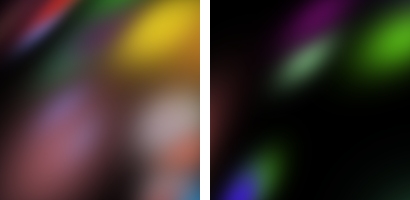

In [4]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)
rasterizer = intrinsics_to_rasterizer(intrinsics, jnp.eye(4))
means3D = torch.tensor(torch.rand((10,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp_gt = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device).detach()
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)

color,_,_,_ = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp_gt,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)
color_gt = color.detach()
gt_viz = b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0)
gt_viz

means3D = torch.tensor(torch.rand((20,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
N = means3D.shape[0]
opacity = torch.tensor(torch.ones((N,1)), requires_grad=True, device=device)
colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device)
scales = torch.tensor(-8.0 * torch.ones((N,3)), requires_grad=True, device=device)
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)
color,depth,depth2,num_rendered = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors_precomp,
    opacities = torch.sigmoid(opacity),
    scales = torch.exp(scales),
    rotations = rotations
)

b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

In [5]:
num_rendered

1666

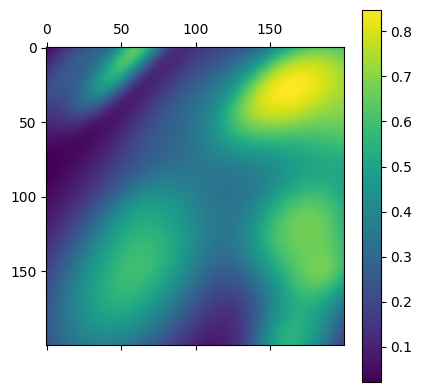

In [6]:
plt.matshow(torch.permute(color, (1,2,0)).cpu().detach().numpy()[...,0])
plt.colorbar()

In [7]:
optimizer = torch.optim.Adam([
    {'params': [colors_precomp], 'lr': 0.01, "name": "pos"},
    {'params': [means3D], 'lr': 0.001, "name": "pos"},
], lr=0.0, eps=1e-15)

pbar = tqdm(range(100))
for _ in pbar:
    color,_,_,_ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = colors_precomp,
        opacities = torch.sigmoid(opacity),
        scales = torch.exp(scales),
        rotations = rotations
    )
    optimizer.zero_grad()
    loss = torch.abs(color_gt - color).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
b.hstack_images([
    b.get_rgb_image(torch.permute(color, (1,2,0)).cpu().detach().numpy() * 255.0),
    gt_viz
])

  0%|          | 0/100 [00:00<?, ?it/s]

: 

In [1]:
BLOCK_X = 16
BLOCK_Y = 16
BLOCK_SIZE = BLOCK_X* BLOCK_Y
num_tiles_x = int((intrinsics.width + BLOCK_X - 1) / BLOCK_X)
num_tiles_y = int((intrinsics.height + BLOCK_Y - 1) / BLOCK_Y)
num_tiles = num_tiles_x * num_tiles_y


# Print all relevant info.

assert tensor_ranges.shape[0] == num_tiles * 2
num_gaussians = gaussian_sorted.shape[0]
assert out_weights.shape[0] == num_gaussians * BLOCK_X* BLOCK_Y

img = np.zeros((intrinsics.height, intrinsics.width))


for tile in tqdm(range(num_tiles)):
    range_x, range_y = tensor_ranges[2*tile], tensor_ranges[2*tile + 1]
    start_index = (BLOCK_SIZE * range_x)
    num_gaussians_in_this_block = range_y - range_x
    for ii in range(BLOCK_X):
        for jj in range(BLOCK_Y):
            pixel_coordinates = tile // num_tiles_y * BLOCK_Y + jj, tile % num_tiles_x * BLOCK_X + ii
            if pixel_coordinates[0] >= intrinsics.height or pixel_coordinates[1] >= intrinsics.width:
                continue
            if num_gaussians_in_this_block == 0:
                # img[pixel_coordinates[0],pixel_coordinates[1]] = intrinsics.far
                continue
            pixel_index_in_block = jj * BLOCK_X + ii
            u,v = (start_index + pixel_index_in_block * num_gaussians_in_this_block, start_index + (pixel_index_in_block + 1) * num_gaussians_in_this_block)
            print(u,v)
            weights = out_weights[u:v]
            maximum_weight = weights.max()

            indices = gaussian_sorted[range_x:range_y]
            values = colors_precomp[indices]

            img[pixel_coordinates[0],pixel_coordinates[1]] = (weights * values[:,0]).sum()
            # img[pixel_coordinates[0],pixel_coordinates[1]] += (1.0 - weights.sum()) * intrinsics.far
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
plt.imshow(depth_image)
plt.colorbar()
ax.set_title("Original")
ax = fig.add_subplot(1,3,2)
plt.imshow(img)
plt.colorbar()
ax.set_title("Reconstructed")
ax = fig.add_subplot(1,3,3)
plt.imshow(depth_image - img)
plt.colorbar()
ax.set_title("Diff")

NameError: name 'intrinsics' is not defined